# **Installing Dependencies**

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2==0.5
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install opencv-python
!pip install scikit-learn

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu111 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0

# **Importing Libraries**

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from sklearn.model_selection import train_test_split
from detectron2.data import DatasetCatalog, MetadataCatalog

# **Mounting Google Drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# **Load a Pretrained Mask R-CNN Model**

In [ ]:
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    for image_filename in os.listdir(image_dir):
        if image_filename.endswith(".jpg") or image_filename.endswith(".png"):
            image_path = os.path.join(image_dir, image_filename)
            mask_path = os.path.join(mask_dir, image_filename)

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is not None and mask is not None:
                image = cv2.resize(image, target_size)
                mask = cv2.resize(mask, target_size)

                images.append(image)
                masks.append(mask)

    return images, masks

image_dir = "/content/drive/MyDrive/images"
mask_dir = "/content/drive/MyDrive/labels"

images, masks = load_images_and_masks(image_dir, mask_dir)

images = np.array(images)
masks = np.array(masks)

print(f"Loaded {len(images)} images and {len(masks)} masks.")
print(f"Image shape: {images[0].shape}, Mask shape: {masks[0].shape}")

Loaded 233 images and 233 masks.
Image shape: (256, 256, 3), Mask shape: (256, 256)


# **Train-test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 186
Test set size: 47


# **Preparing Dataset**

In [ ]:
def create_dicts_from_images_and_masks(image_dir, mask_dir):
    dataset_dicts = []

    image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
    mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

    assert len(image_filenames) == len(mask_filenames), "The number of images and masks do not match!"

    for image_filename, mask_filename in zip(image_filenames, mask_filenames):
        record = {}

        image_path = os.path.join(image_dir, image_filename)
        mask_path = os.path.join(mask_dir, mask_filename)

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        height, width = image.shape[:2]
        record["file_name"] = image_path
        record["image_id"] = image_filename
        record["height"] = height
        record["width"] = width

        annotations = []
        carving_class_id = 1
        background_class_id = 0

        carving_mask = (mask == 255).astype(np.uint8)
        contours, _ = cv2.findContours(carving_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            segmentation = contour.reshape(-1).tolist()
            bbox = cv2.boundingRect(contour)

            annotation = {
                "bbox": [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": carving_class_id,
                "segmentation": [segmentation],
            }
            annotations.append(annotation)

        record["annotations"] = annotations
        dataset_dicts.append(record)

    return dataset_dicts

image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg") or f.endswith(".png")])
mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])

train_split = int(0.8 * len(image_filenames))
X_train = image_filenames[:train_split]
y_train = mask_filenames[:train_split]

X_test = image_filenames[train_split:]
y_test = mask_filenames[train_split:]

if "my_dataset_train" in DatasetCatalog:
    DatasetCatalog.remove("my_dataset_train")
if "my_dataset_test" in DatasetCatalog:
    DatasetCatalog.remove("my_dataset_test")

DatasetCatalog.register("my_dataset_train", lambda: create_dicts_from_images_and_masks(image_dir, mask_dir))
MetadataCatalog.get("my_dataset_train").set(thing_classes=["background", "carving"])

DatasetCatalog.register("my_dataset_test", lambda: create_dicts_from_images_and_masks(image_dir, mask_dir))
MetadataCatalog.get("my_dataset_test").set(thing_classes=["background", "carving"])

namespace(name='my_dataset_test', thing_classes=['background', 'carving'])

# **Configure the Model & Train**

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/22 16:55:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[04/22 16:56:21 d2.engine.train_loop]: Starting training from iteration 0
[04/22 16:56:32 d2.utils.events]:  eta: 0:03:52  iter: 19  total_loss: 2.546  loss_cls: 1.098  loss_box_reg: 0.6621  loss_mask: 0.6858  loss_rpn_cls: 0.08488  loss_rpn_loc: 0.022    time: 0.5043  last_time: 0.5302  data_time: 0.0982  last_data_time: 0.0127   lr: 9.7405e-06  max_mem: 3471M
[04/22 16:56:41 d2.utils.events]:  eta: 0:03:23  iter: 39  total_loss: 2.257  loss_cls: 0.832  loss_box_reg: 0.6189  loss_mask: 0.6739  loss_rpn_cls: 0.04408  loss_rpn_loc: 0.02115    time: 0.4803  last_time: 0.4678  data_time: 0.0420  last_data_time: 0.0011   lr: 1.9731e-05  max_mem: 3471M
[04/22 16:56:52 d2.utils.events]:  eta: 0:03:20  iter: 59  total_loss: 1.904  loss_cls: 0.5376  loss_box_reg: 0.5993  loss_mask: 0.6507  loss_rpn_cls: 0.0299  loss_rpn_loc: 0.01963    time: 0.5035  last_time: 0.6498  data_time: 0.0811  last_data_time: 0.1313   lr: 2.972e-05  max_mem: 3471M
[04/22 16:57:02 d2.utils.events]:  eta: 0:03:11  iter

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **Test the Model**

[04/22 17:05:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


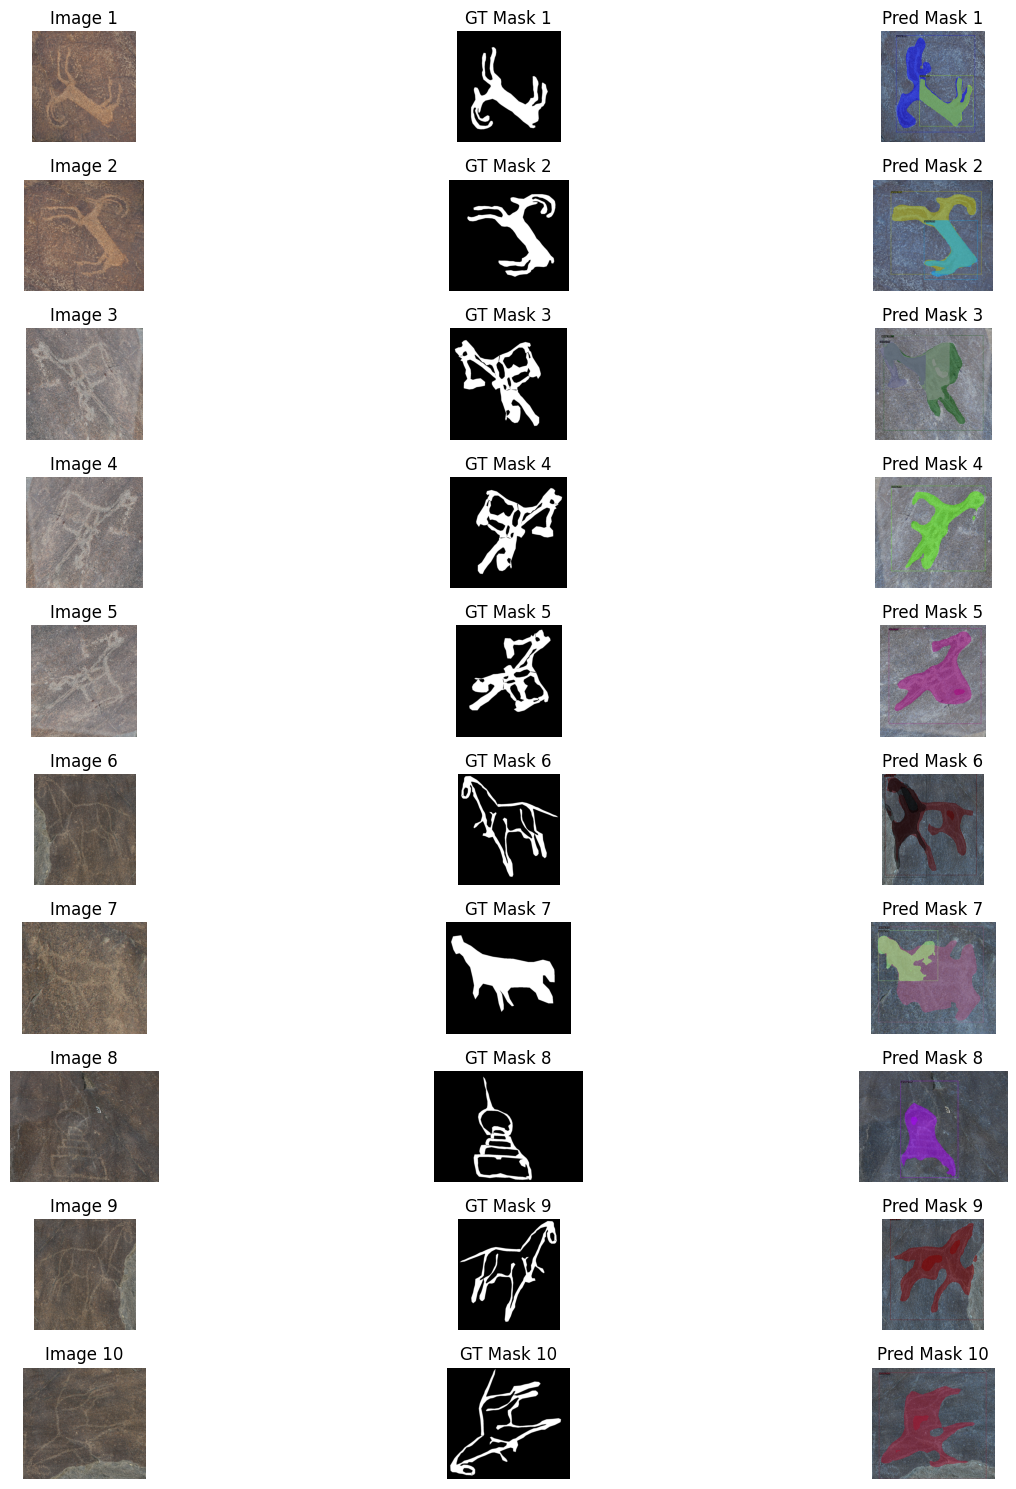

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

num_images = 10
plt.figure(figsize=(15, 15))
for i in range(min(num_images, len(X_test))):
    test_image_filename = os.path.join(image_dir, X_test[i])
    test_image = cv2.imread(test_image_filename)
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    test_mask_filename = os.path.join(mask_dir, y_test[i])
    test_mask = cv2.imread(test_mask_filename, cv2.IMREAD_GRAYSCALE)

    outputs = predictor(test_image)

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(test_image_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title(f"GT Mask {i+1}")
    plt.axis('off')

    v = Visualizer(test_image_rgb[:, :, ::-1], MetadataCatalog.get("my_dataset_train"), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(v.get_image())
    plt.title(f"Pred Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Testing The Model on Roboflow**

[04/22 17:24:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


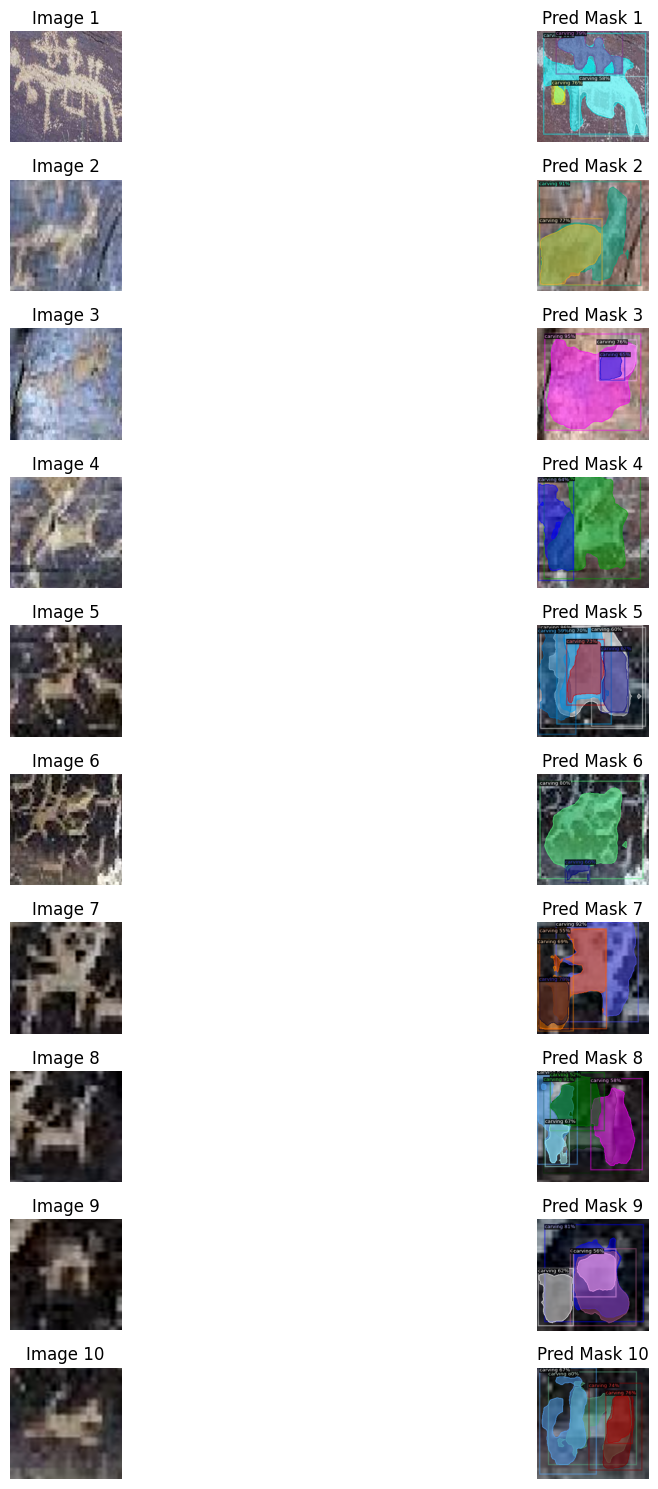

In [ ]:
cropped_image_dir = "/content/drive/MyDrive/cropped_images"

cropped_image_filenames = sorted([f for f in os.listdir(cropped_image_dir) if f.endswith(".jpg") or f.endswith(".png")])

plt.figure(figsize=(15, 15))

num_images = min(10, len(cropped_image_filenames))

for i in range(num_images):
    image_filename = cropped_image_filenames[i]
    image_path = os.path.join(cropped_image_dir, image_filename)
    test_image = cv2.imread(image_path)
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    outputs = predictor(test_image)
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(test_image_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')

    v = Visualizer(test_image_rgb[:, :, ::-1], MetadataCatalog.get("my_dataset_train"), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(v.get_image())
    plt.title(f"Pred Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()